# Pre Elaborazione dei dati

La qualità del dato sono un fattore chiave per la buona riuscita di un progetto di machine learning. 
Pertanto è necessario controllare i dati prima di inserirli in un algoritmo di machine learning.

In questa notebook tratteremo i seguenti argomenti:

* Gestione dei valori mancanti
* I dati categorici
* Selezione delle caratteristiche più rilevanti

## I dati mancanti
E' molto probabile che andremo a scontrarci con questa problematica, utilizzando pandas come libreria potremo avere dei valori Null oppure contrassegnati come NaN (Not a Number).

### Rimozione dei dati mancanti
Come prima soluzione si potrebbe pensare di eliminare le righe o le colonne in cui mancano i dati con il comando di pandas ``df.drop_na()``. Questa soluzione sebbene sia semplice potrebbe portare alla cancellazione di troppi dati e pregiudicare l'affidabilità del sistema. 

### Imputazione dei dati mancanti
Una soluzione per evitare la cancellazione dei dati mancanti è l'interpolazione, ad esempio potremmo sostituire il dato mancante con il valore medio della colonna.
Sklearn fornisce uno strumento molto utile ``Imputer`` che si occupa di sostituire i valori mancanti con il valore medio della colonna

In [1]:
import pandas as pd
import numpy as np

data = {
    "A": [1,5,10],
    "B": [2,6,4],
    "C": [3,np.nan,12],
    "D": [4,8,np.nan]
}

df = pd.DataFrame(data)
df

,A,B,C,D
0,1,2,3.0,4.0
1,5,6,NaN,8.0
2,10,4,12.0,NaN


In [2]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')

imp.fit(df)
imp.transform(df)

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. ,  4. , 12. ,  6. ]])

### La classe SimpleImputer

La classe SimpleImputer appartiene alle classi *trasformer* utilizzate per la trasformazione dei dati i due metodi principali di questi stimatori sono *fit* e *transform*. Il metodo ``fit`` viene utilizzato per apprendere i parametri dai dati di addestramento mentre il transform utilizza questi dati per effettuare la modifica dei valori *NaN*.

Gli stimatori differiscono dai transformer in quanto di solito utilizzano il metodo ``predict`` ma possono anche loro avere il metodo ``transform``, inoltre negli stessi il metdo ``fit`` in ingresso vuole anche le etichette per eseguire l'addestramento del modello.

## Gestione delle categorie

L'esempio predente faceva rifermento a dati numerici, tuttavia potrebbe succedere di avere a che fare con delle categorie ad esempio le taglie (XL > L > M > S). Le categorie possono essere divise in *nominali* e *ordinali*. Le categorie ordinali possono essere ordinate vedi ad esempio le taglie, mentre le categorie nominali non prevedono alcun ordine ad esempio i colori.
Come potremmo gestire questi dati ? Vediamo un esempio pratico.

In [3]:
data = {
    "Color": ["Green","Red","Blue"],
    "Size": ["M","L","XL"],
    "Price": [10,13,15],
    "Label": ["Class1","Class2","Class1"]
}

df = pd.DataFrame(data)
df

,Color,Size,Price,Label
0,Green,M,10,Class1
1,Red,L,13,Class2
2,Blue,XL,15,Class1


### Gestione delle categorie ordinali

Le categorie ordinali possono tranquillamente essere gestite con la funzione pandas ``map`` vediamo in esempio pratico

In [4]:
size_mapping = {
    'XL':3,
    'L':2,
    'M':1
}

df['Size'] = df['Size'].map(size_mapping)
df

,Color,Size,Price,Label
0,Green,1,10,Class1
1,Red,2,13,Class2
2,Blue,3,15,Class1


se volessimo ritornare ai valori precedenti bastera creare il dizionario inverso

In [5]:
inverse = {v:k for k,v in size_mapping.items()}
inverse

{3: 'XL', 2: 'L', 1: 'M'}

## Codifica delle etichette 
La maggior parte degli estimatori di sklearn vuole in ingresso un numero intero, sebbene sklearn converta internamente le classi in numeri sarebbe meglio che venissero trasformati in numeri.
Per fare questo si può utilizzare la classe ``LabelEncoder``

In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y = le.fit_transform(df['Label'].values)
y

array([0, 1, 0])

Questa classe permette anche di risalire ai valori originali

In [7]:
le.inverse_transform(y)

array(['Class1', 'Class2', 'Class1'], dtype=object)

## Gestione dei valori nominali 

Come abbiamo detto prima alcune funzionalità non possono essere semplicemente trasformate in un numero in quanto non hanno alcun ordine specifico. Per codificare questo tipo di valori viene utilizzata la codifica *one-hot*.
L'idea alla base di questa codifica è che si viene a creare una feature fittizzia per ogni valore della colonna, nel nostro caso avremo tre colonne nuove Green,Red e Blue con un valore binario associato. Vediamo un esempio:

In [8]:
from sklearn.preprocessing import OneHotEncoder

one = OneHotEncoder()
data = one.fit_transform(df["Color"].values.reshape(-1, 1))
data.todense()

matrix([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]])

Per trasformare direttamente la colonna nel dataset bisogna utilizzare un transformer

In [9]:
from sklearn.compose import ColumnTransformer

column = ColumnTransformer([
    ('onehot',OneHotEncoder(),[0]),
    ('nothing','passthrough',[1,2])
])

column.fit_transform(df)

array([[ 0.,  1.,  0.,  1., 10.],
       [ 0.,  0.,  1.,  2., 13.],
       [ 1.,  0.,  0.,  3., 15.]])

oppure si può utilizzare il comodo metodo di pandas ``get_dummies``

In [10]:
Y = df.pop('Label')
pd.get_dummies(df)

,Size,Price,Color_Blue,Color_Green,Color_Red
0,1,10,0,1,0
1,2,13,0,0,1
2,3,15,1,0,0


## Target encoding



Come detto prima le categorie sono preziose per gli algoritmi di machine learning ma a volte le relazioni contenute all'interno della stessa sono difficili da catturare per la maggior parte dei modelli.
Il target encoding è un processo di codifica che può essere definito come:

La feature viene sostituita con una miscela della probabilità a priori a cui la categoria appartiene e quella a posteriori del target su tutti i dati di addestramento.

Per semplificare la spiegazione creiamo un semplice dataset su cui andremo a fare i nostri ragionamenti.

In [11]:
import pandas as pd

df = pd.DataFrame({
    'x0': ['a'] * 5 + ['b'] * 5,
    'x1': ['c'] * 9 + ['d'] * 1,
    'y': [1, 1, 1, 1, 0, 1, 0, 0, 0, 0]
})

df

,x0,x1,y
0,a,c,1
1,a,c,1
2,a,c,1
3,a,c,1
4,a,c,0
5,b,c,1
6,b,c,0
7,b,c,0
8,b,c,0
9,b,d,0


Calcoliamo le medie delle varie categorie e vediamo come rimpiazzarle sulla colonna originale

In [12]:
means = df.groupby('x0')['y'].mean()
means

x0
a    0.8
b    0.2
Name: y, dtype: float64

In [13]:
df['x0'].map(means)

0    0.8
1    0.8
2    0.8
3    0.8
4    0.8
5    0.2
6    0.2
7    0.2
8    0.2
9    0.2
Name: x0, dtype: float64

e facciamo lo stesso ragionamento con la colonna x1.
La codifica target è buona perchè trasforma le categorie in un valore che può aiutare a spiegare il target, questa soluzione però ha un problema e si chiama overfitting. Fare affidamento alla media non sempre è una buona idea, specialmente se il numero dei valori in una categoria è basso. 

Bisogna sempre pensare che il dato su cui noi stiamo addestrando il modello è un campione dell'insieme dei dati e alcune relazioni che stiamo scovando non è detto che rappresentino la realtà, questo lo si può verificare con il dataset di test.

Un esempio pratico del problema lo si vede qui sotto, la categoria d ha solo un record e viene rappresentata con lo 0.
Ci sono vari modi per trattare questa problematica la prima è usare la cross validation che vedremo più avanti la seconda è la tecnica di *adaptive smoothing*.

In [14]:
df['x1'].map(df.groupby('x1')['y'].mean())

0    0.555556
1    0.555556
2    0.555556
3    0.555556
4    0.555556
5    0.555556
6    0.555556
7    0.555556
8    0.555556
9    0.000000
Name: x1, dtype: float64

L'intuizione che sta dietro a questa tecnica è la seguente, "smussare" la media includendo anche la media di tutti gli elementi. in altre parole se non ci sono molte valutazioni ci si baserebbe di più sulla media globale mentre se ci sono abbastanza valori si può far affidamento sulla media locale.

La formula di trasformazione si può esprimere nel seguente modo:$$ \mu = \frac{n \times \bar{x} + m \times w}{n + m} $$

+ $\mu$ è il valore che vogliamo ottenere
+ $n$ è il numero di campioni che abbiamo della classe
+ $\bar{x}$ è la nostra stima della media
+ $m$ è il peso che vogliamo dare alla media complessiva
+ $w$ è la media complessiva

$m$ è un parametro che va impostato, l'idea è che più lo stesso sarà grande più la media complessiva avrà importanza.
Ad esempio con $m = 0$ avremo che:

$$ \mu = \frac{n \times \bar{x} + 0 \times w}{n + 0} =  \frac{n \times \bar{x}}{n}$$

la funzione è facilmente implementabile in pyhton

In [15]:
def calc_smooth_mean(df, by, on, m):
    #Calcolo la media globale
    mean = df[on].mean()

    #Calcolo il numero di valori e la media per ogni gruppo
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    #Calcolo la media "smussata"
    smooth = (counts * means + m * mean) / (counts + m)

    #Rimpiazzo ogni classe con la media calcolata prima
    return df[by].map(smooth)

In [16]:
df['x0'] = calc_smooth_mean(df, by='x0', on='y', m=10)
df['x1'] = calc_smooth_mean(df, by='x1', on='y', m=10)

df

,x0,x1,y
0,0.6,0.526316,1
1,0.6,0.526316,1
2,0.6,0.526316,1
3,0.6,0.526316,1
4,0.6,0.526316,0
5,0.4,0.526316,1
6,0.4,0.526316,0
7,0.4,0.526316,0
8,0.4,0.526316,0
9,0.4,0.454545,0


## Partizionare il dataset in due insiemi separati train e test

Per valutare le performance di un algoritmo di ml è sempre bene utilizzare dei dati nuovi, per valutare le sue capacità previsionali. Stiamo per iniziare a creare le nostre prime soluzioni di ml come primo passo andremo ad utilizzare un dataset molto semplice che contiente le caratteristiche di 178 vini italiani con 13 caratteristiche che descrivono le sue proprietà.
Come prima cosa carichiamo il dataset

In [17]:
from sklearn.datasets import load_wine
wine = load_wine()

per comodità di visualizzazione trasformiamo l'array numpy in un dataframe pandas

In [18]:
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names)

In [19]:
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


Visualizziamo anche le etichette che fanno rifermento a tre diversi tipi di vitigni che crescono in diverse zone d'italia

In [20]:
wine.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

Ora come detto prima andiamo a dividere utilizzando la libreria sklearn il dataset in due parti quella di addestramento e quella di test.



In [21]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(wine.data,wine.target,test_size = 0.3)

con il metodo sopra abbiamo diviso il dataset in modo casuale in modo da avere il 70% dei dati nel dataset di train e il restante 30% in quello di test. La scelta della dimensione del dataset di test è molto importante in quanto più dati daremo al datest di test e più sotrarremo informazioni importanti alla fase di addestramento mentre se daremo troppi dati al dataset di train rederemo inutile il dataset stesso, le dimensioni di sono 60/40 oppure 70/30 o 80/20 per dataset particolarmente grandi si può anche arrivare ad un rapporto 99/1

## Portare tutte le caratteristiche sulla stessa scala

Portare tutte le carattertiche sulla stessa scala è un buon inizio in quanto molti algoritmi potrebbero avere dei problemi nella fase di training, per fare un esempio pratico supponiamo di avere due features con due scale diverse una con valori che vanno da 1 a 10 e una con valori da 1 e 100000 se ci ragioniamo un'attimo l'algoritmo sarà più occupato a minimizzare gli errori che porta la seconda caratteristica rispetto alla prima.

Ora vi sono due approcci di riduzione di scala la *normalizzazione* e la *standardizzazione* e talvolta questi due termini sono usati come lo stesso, in realtà definiamo come:

* La normalizzazione fa riferimento ad un cambio di scala che porta il risultato ad avere valori compresi tra [0,1]
* La standardizzazione fa in modo che la caratteristica abbia la media con valore 0 e deviazione standard 1

La normalizzazione può essere espressa con la seguente formula $$x^i_{norm} = \frac{x^i - x_{min}}{x_{max} - x_{min}}$$

La standardizzazione invece si può esprimere nel seguente modo $$x^i_{std} = \frac{x^i - \mu_x}{\sigma_x}$$ 

dove $\mu_x$ rappresenta la media di x mentre $\sigma_x$ rappresenta la deviazione standard.
Vediamo un esempio pratico qui sotto utilizzando le funzioni messe a disposizione da sklearn

In [22]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

mms = MinMaxScaler()
stds = StandardScaler()

test_scaler = pd.DataFrame(np.arange(10),columns =["Input"])
test_scaler['Normalizzato'] = mms.fit_transform(test_scaler["Input"].values.reshape(-1, 1))
test_scaler['Standardizzato'] = stds.fit_transform(test_scaler["Input"].values.reshape(-1, 1))

#eseguo la standardizzazione anche sul dataset wine in quanto andremo ad utilizzare più avanti quei valori
X_train_std = stds.fit_transform(X_train)
X_test_std = stds.transform(X_test)


In [23]:
test_scaler

,Input,Normalizzato,Standardizzato
0,0,0.000000,-1.566699
1,1,0.111111,-1.218544
2,2,0.222222,-0.870388
3,3,0.333333,-0.522233
4,4,0.444444,-0.174078
5,5,0.555556,0.174078
6,6,0.666667,0.522233
7,7,0.777778,0.870388
8,8,0.888889,1.218544
9,9,1.000000,1.566699


Vediamo un esempio più dettagliato di come la distribuzione dei valori cambia con i due esempi di normalizzazione

Text(0.5, 1.0, 'Standardized data')

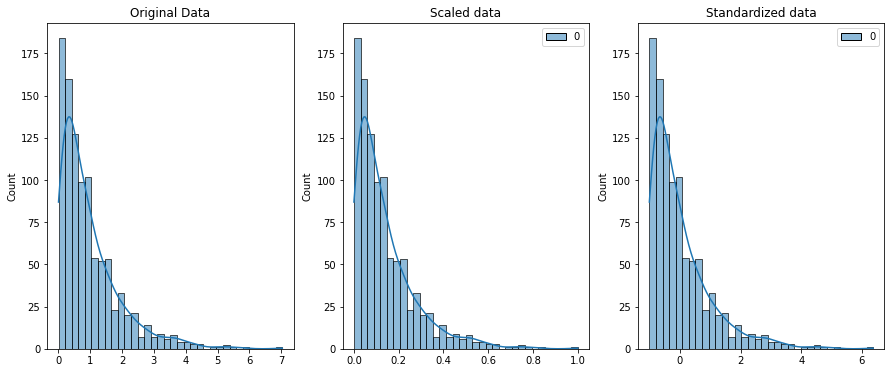

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


original_data = np.random.exponential(size=1000)
scaled_data = mms.fit_transform(original_data.reshape(-1, 1))
normalized_data = stds.fit_transform(original_data.reshape(-1, 1))
#normalized_data = stats.boxcox(original_data)[0]

fig, ax=plt.subplots(figsize=(15,6),nrows=1,ncols=3)
sns.histplot(data=original_data, kde=True,ax=ax[0])
ax[0].set_title("Original Data")
sns.histplot(data=scaled_data, kde=True,ax=ax[1])
ax[1].set_title("Scaled data")
sns.histplot(data=normalized_data, kde=True,ax=ax[2])
ax[2].set_title("Standardized data")


### Normalizzare la distribuzione dei valori

La scalatura dei dati cambia solo l'intervallo dei dati la normalizzazione della distribuzione cambia completamente la distribuzione dei valori in modo da farla arrivare ad una distribuzione normale, la famosa curva a campana.


Text(0.5, 1.0, 'Normalized data')

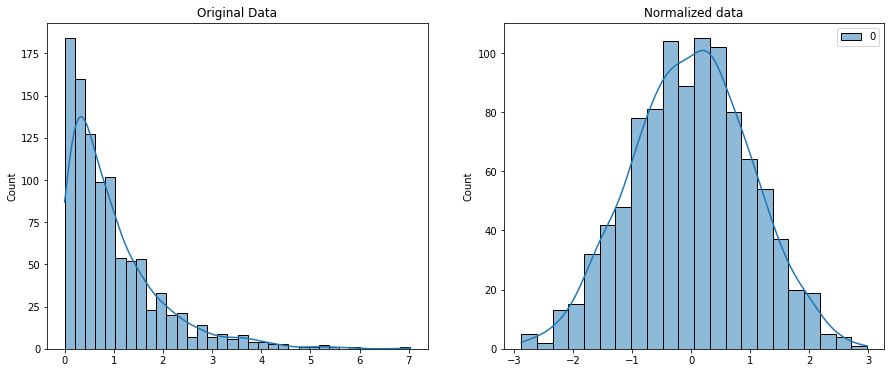

In [25]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='box-cox')

normalized_data = pt.fit_transform(original_data.reshape(-1, 1))

fig, ax=plt.subplots(figsize=(15,6),nrows=1,ncols=2)
sns.histplot(data=original_data, kde=True,ax=ax[0])
ax[0].set_title("Original Data")
sns.histplot(data=normalized_data, kde=True,ax=ax[1])
ax[1].set_title("Normalized data")

## Selezione delle caratteristiche appropiate

Quando notiamo che un modello si comporta meglio nel dataset di training rispetto la test, molto probabilmente siamo di fronte ad un problema di *overfitting* per ovviare a questo problema le strategie per risolvere il problema possono essere :

* raccogliere più dati di addestramento
* introdurre una penalità sulla complessità mediante la regolarizzazione
* scegliere un modello più semplice
* ridurre la dimensionalità dei dati

La prima soluzione non è sempre possibile, nella prossima parte affronteremo la regolarizzazione nel dettaglio.

### Soluzioni sparse, la regolarizzazione L1

Nella lezione scorsa abbiamo introdotto il concetto di regolarizzazione *L2* che introduce una penalità sulla complessità del modello penalizzando i pesi con valori elevati. La formula di penalizzazione L2 si può esprimere come:
$$\lVert w \rVert^2 = \sum_{j=1}^{m} w_j^2$$
Un'altro approccio per la riduzione della complessità è la regolarizzazione *L1* che si può scrivere in questo modo:
$$\lVert w \rVert = \sum_{j=1}^{m} \left|w_j\right|$$
Abbiamo semplicemente sostituito la somma del quadrato dei pesi con con il valore assoluto.
La soluzione L1 rispetto alla L2 restituisce soluzioni sparse andiamo visualizzare il perchè.
Andiamo innanzitutto ad analizzare l'andamento delle due funzioni di costo.

<a list of 17 text.Text objects>

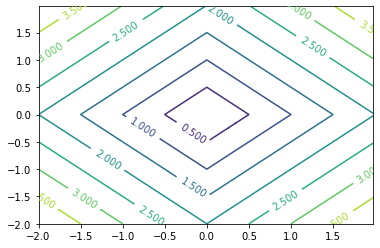

In [26]:
import numpy as np
import matplotlib.pyplot as plt

x_min = -2
x_max = 2
resolution=0.02
xx1, xx2 = np.meshgrid(np.arange(x_min, x_max, resolution), np.arange(x_min, x_max, resolution))

Z1 = np.abs(xx1) + np.abs(xx2)
CS = plt.contour(xx1, xx2, Z1)
plt.clabel(CS, inline=1, fontsize=10)


<a list of 15 text.Text objects>

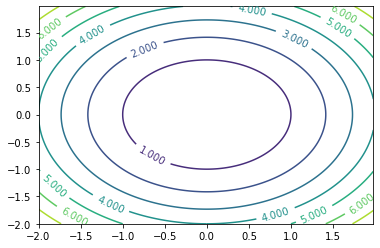

In [27]:
Z2 = xx1 ** 2 + xx2 ** 2
CS = plt.contour(xx1, xx2, Z2)
plt.clabel(CS, inline=1, fontsize=10)

Per comprendere meglio il concetto che si vuol esporre tracciamo la funzione di costo di due coefficienti $w_1$ e $w_2$ con sovrapposta la funzione di costo dei pesi L1 e L2.

![costi l1 e l2](./images/costiL1L2.png)

Il nostro scopo è quello di trovare un punto di equilibrio tra il costo della funzione di errore e il costo della normalizzazione, la normalizzazione ha lo scopo di incoraggiare l'uso di pesi con valori piccoli più possibile vicini allo zero mentre la funzione di errore ovviamente vuol minimizzare gli errori.

Se aumentiamo l'importanza della normalizzazione avremo che i pesi saranno il più possibile vicino allo 0 ora possiamo pensare che la normalizzazione tracci un recinto che i nostri pesi non possano superare, ovviamente si vuol anche diminuire il più possibile la funzione di costo la soluzione a questo problema è il punto di incontro tra i due costi.

Ora vediamo che la norma 2 dei pesi ha un andamento che traccia dei cerchi mentre la norma 1 traccia dei rombi. Ora poichè i contorni della funzione di norma 1 sono più netti è più probabile che la soluzione del problema sia situata su uno dei due assi, ma ciò vuol dire che il valore di quel peso è zero.
Possiamo dunque dire che la norma 1 favorisce soluzioni sparse è ciò e bene in sistemi dove abbiamo molte features che magari non apportano nessun vantaggio nella soluzione.

Per impostare la penalità L1 con sklearn va impostato il parametro,  ``penalty`` a  ``L1``

In [28]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1',solver='liblinear',C=0.1)
lr.fit(X_train_std,y_train)

print("Accuracy train dataset: {0:.2f}".format(lr.score(X_train_std,y_train)))
print("Accuracy test dataset: {0:.2f}".format(lr.score(X_test_std,y_test)))

Accuracy train dataset: 0.98
Accuracy test dataset: 0.93


ora come si vede non siamo di fronte ad una situazione di overfitting, qualcuno si sarà accorto che non siamo di fronte ad un problema di classificazione binario in quanto ora le classi dei vini sono ben 3 come ha fatto la regressione logistica che lavora su problemi binari a classificare correttamente un problema multiclasse ?

### One vs Rest (OvR) e One vs One (OvO)
Il sistema Ovr è un metodo euristico per usare un classificatore binario su un problema multiclasse. Si porta il problema multiclasse in più problemi binari e per ogni problema binario si prende la soluzione più confidente. Riprendiamo il nostro datese dei vini con le tre classi: *class 0*,*class 1*,*class 2* avremo dunque 3 problemi di classificazione:

* Problema binario 1: *class 0* vs *class 1 e class 2*
* Problema binario 2: *class 1* vs *class 0 e class 2*
* Problema binario 3: *class 2* vs *class 0 e class 1*

Ora come si può notare all'aumentare delle classi aumenta il numero di modelli da addestrare.

Il sistema OvO è un sistema come l'OvR che porta i problemi multiclasse in problemi binari ma genera i dataset di addestramento in un modo differente:

* Problema binario 1: *class 0* vs *class 1*
* Problema binario 2: *class 0* vs *class 2*
* Problema binario 3: *class 1* vs *class 2*

Il numero dei modelli aumenta significativamente rispetto all'aumentare delle classi e si può calcolare con la formuletta con $\mu$ il numero delle classi:

$$\frac{(\mu * (\mu-1))}{2}$$

per ogni classe si sommano i punteggi e viene scelta la classe con il punteggio maggiore, questo approccio viene suggerito per le SVM e gli altri algoritmi basati sul kernel.

### analisi dei pesi 

andiamo ora ad analizzare i pesi calcolati con la regressione logistica sul dataset wine come prima cosa analizziamo i valori di intercettazione.

In [29]:
lr.intercept_

array([-0.21941668, -0.14066809, -0.82733052])

come abbiamo scritto prima poichè stiamo adattando un algoritmo di classificazione binaria su un dataset multiclasse mediante l'approccio OvR avremo tre modelli.

Andiamo ad analizzare i coefficenti di peso 

In [30]:
lr.coef_

array([[ 0.30096641,  0.        ,  0.        , -0.20388104,  0.        ,
         0.        ,  0.66958741,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.30380992],
       [-0.69788142,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -1.09943469,
         0.        ,  0.        , -0.392793  ],
       [ 0.        ,  0.09798631,  0.        ,  0.        ,  0.        ,
         0.        , -0.71674605,  0.        ,  0.        ,  0.64437156,
        -0.28578694, -0.36031498,  0.        ]])

come si vede molti parametri sono impostati a 0, tracciamo il percorso di regolarizzazione che è costruito dai coeffienti di peso delle varie caratterstiche al variare della regolarizzazione.

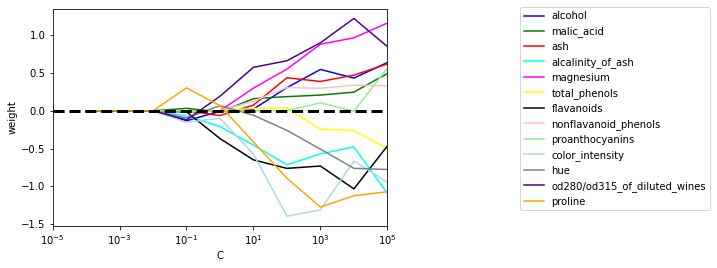

In [31]:
fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue','green','red','cyan','magenta','yellow','black','pink','lightgreen','lightblue','gray','indigo','orange']

weights,params = [],[]
for c in np.arange(-4.,6.):
    lr = LogisticRegression(penalty='l1',solver='liblinear',C=10.**c)
    lr.fit(X_train_std,y_train)
    weights.append(np.mean(lr.coef_, axis=0))
    params.append(10.**c)
    
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]),colors):
    plt.plot(params,weights[:,column],label = wine.feature_names[column], color=color)

plt.axhline(0,color='black',linestyle = '--',linewidth = 3)
plt.xlim([10**-5,10**5])
plt.xlabel('C')
plt.ylabel('weight')
plt.xscale('log')
plt.legend(loc="upper left")
ax.legend(loc="upper left",bbox_to_anchor=(1.38,1.03),ncol=1,fancybox=True)

## Algoritmi per la selezioni delle caratteristiche

un altro sistema per la diminuzione della complessità del modello ed evitare il problema dell'**overfitting** è la *riduzione della dimensionalità*. 
Vi sono due categorie principali di tecniche per la riduzione della dimensionalità: *selezione delle caratteristiche* e *estrazione delle caratteristiche*.
Nella selezione si utilizza un algoritmo che seleziona solo le feature che apportano un beneficio, mentre nell'estrazione si utilizzano delle tecniche che comprimono il dataset in uno spazio vettoriale con una dimensionalità ridotta.

Gli algoritmi sequenziali per la selezione delle caratteristiche fanno parte della famiglia di algoritmi *greedy* e vengono utilizzati per ridurre lo spazio delle caratteristiche da d dimensioni a k dimensioni con **k<d**.
L'idea su cui si basano gli algoritmi per la selezione delle caratteristiche si consiste nel selezionare automaticamente un sottoinsieme delle stesse, riducendo la dimensionalità con un decadimento minore possibile in termine di prestazioni del classficatore, questo porta un aumento dell'efficienza computazionale globale.



In [32]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
sfs = SequentialFeatureSelector(knn, n_features_to_select=5)
sfs.fit(X_train,y_train)

feature_names = wine.feature_names
for i,data in enumerate(sfs.get_support()):
    if data:
        print(feature_names[i])

ash
total_phenols
flavanoids
nonflavanoid_phenols
color_intensity


In [33]:
knn.fit(X_train,y_train)
print("Accuracy test dataset: {0:.2f}".format(knn.score(X_test,y_test)))

Accuracy test dataset: 0.59


In [34]:
knn.fit(X_train[:,sfs.get_support()],y_train)
print("Accuracy test dataset: {0:.2f}".format(knn.score(X_test[:,sfs.get_support()],y_test)))

Accuracy test dataset: 0.91


### Valutazione delle caratteristiche mediante foreste di alberi 

Nella parte scorsa abbiamo imparato ad utilizzare la regolarizzazione L1 e gli algoritmi per la sezione delle features, ora vediamo un ulteriore sistema per la selezione delle caratteristiche utilizzando le foreste di alberi decisionali.

Utilizzando una foresta di alberi casuali si può misurare l'importanza di ogni features andando a misurare la riduzione dell'impurità ad ogni split e questa misura viene effettuata senza alcuna supposizione che i dati siano separabili linearmente o meno.

Il ``RandomForestClassifier`` contiene l'attributo ``features_importances_`` vediamo come estrarre le informazioni: 

In [35]:
from sklearn.ensemble import RandomForestClassifier



forest = RandomForestClassifier(n_estimators = 500)
forest.fit(X_train,y_train)

importances = forest.feature_importances_
indexes = np.argsort(importances)[::-1]

for i,f in enumerate(indexes):
    print("{0:2} {1:30} {2:.2f}".format(i+1,wine.feature_names[f],importances[f]))


 1 color_intensity                0.18
 2 proline                        0.16
 3 flavanoids                     0.16
 4 alcohol                        0.11
 5 od280/od315_of_diluted_wines   0.10
 6 hue                            0.09
 7 total_phenols                  0.05
 8 malic_acid                     0.03
 9 alcalinity_of_ash              0.03
10 magnesium                      0.02
11 proanthocyanins                0.02
12 nonflavanoid_phenols           0.01
13 ash                            0.01


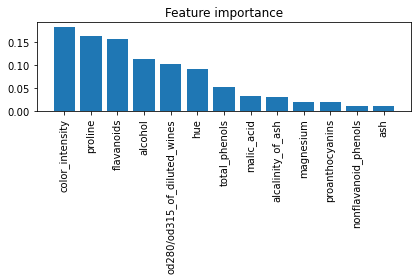

In [36]:
plt.title('Feature importance')
plt.bar(range(len(indexes)),importances[indexes])
plt.xticks(range(len(indexes)),df_wine.columns[indexes],rotation=90)

plt.tight_layout()

Se si nota i valori dati alle features sono normalizzati e la somma da 1 per eseguire la selezione in modo automatico delle caratteristiche si può utilizzare il metodo ``transform`` che seleziona le caratteriche in base ad una soglia preimpostata.



In [38]:
from sklearn.feature_selection import SelectFromModel


sfm = SelectFromModel(forest,threshold = 0.1,prefit = True)
X_selected = sfm.transform(X_train)
X_selected.shape[1]

5

## Mutual information

Nella teoria dell'informazione la mutua informazione è una misura che stima quanto due variabili sono legate tra loro, nel senso se conoscessi il valore di una misura quanto sarei sicuro nella stima del valore della seconda?

Il minor valore possibile è 0 e indica che le due variabili non sono correlate, al contrario non esite un limite superiore ma valori che superino 2 sono molto rari, l'informazione mutua è un valore che cresce in modo logaritmico.

Questo sistema è molto utile quando si è di fronte ad un problema di regressione

In [45]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)
mi_scores = mutual_info_regression(X, y, discrete_features=False)
indexes = np.argsort(mi_scores)[::-1]
for i in indexes[:10]:
    print("{0:3} {1:.2f}".format(i,mi_scores[i]))

 60 0.15
 92 0.15
 40 0.12
  9 0.08
 95 0.06
 24 0.06
 34 0.05
 87 0.05
 99 0.04
 77 0.04
